In [1]:
import matplotlib.pyplot as plt
import numpy as np

import json, os, re
from collections import defaultdict
from itertools import cycle, islice

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Analysis of precision and recall values for different pattern sets

## Visualization ideas
- spamogram with correct and incorrect matches visible

The following patterns, generated by Rasbhari, have been used (number after `w` is weight, after `d` is number of don't care positions:


In [2]:
!ls ../pattern_sets/data/

w-3_d-3.out  w-4_d-4.out   w-5_d-11.out  w-5_d-8.out   w-7_d-3.out  w-7_d-9.out
w-3_d-4.out  w-4_d-5.out   w-5_d-3.out	 w-5_d-9.out   w-7_d-4.out
w-3_d-5.out  w-4_d-6.out   w-5_d-4.out	 w-7_d-10.out  w-7_d-5.out
w-3_d-6.out  w-4_d-7.out   w-5_d-5.out	 w-7_d-11.out  w-7_d-6.out
w-3_d-7.out  w-4_d-8.out   w-5_d-6.out	 w-7_d-12.out  w-7_d-7.out
w-4_d-3.out  w-5_d-10.out  w-5_d-7.out	 w-7_d-13.out  w-7_d-8.out


In [3]:
data = defaultdict(lambda: defaultdict(dict))
for file in os.listdir('.'):
    if file.startswith('RV'):
        directory = file
    else:
        continue
    for file in os.listdir(directory):
        match = re.search('(\d+)[^\d]*(\d+)', file)
        weight = match[1]
        dont_care = match[2]
        with open(f'{directory}/{file}') as f:
            data[directory][int(weight)][int(dont_care)] = json.load(f)

In [13]:
def flatten(nested_list):
    return [item for sublist in nested_list for item in sublist]

def unzip(zipped_data):
    return list(zip(*zipped_data))

def extract_prec_rec(data):
    return [(item['precision'], item['sum_of_pairs']) for item in data]



In [5]:
rv20 = data['RV20']

In [6]:
prec_rec = defaultdict(list)
for name, category in data.items():
    for by_weight in category.values():
        for evaluation in by_weight.values():
            for item in evaluation['results']:
                prec_rec[name].append((item['precision'], item['sum_of_pairs']))
prec_rec = sorted(prec_rec.items(), key= lambda el: el[0])

In [7]:
f_scores = []
for name, category in data.items():
    if name != 'RV20':
        continue
    for weight, weight_data in category.items():
        for dont_care, evaluation in weight_data.items():
            for item in evaluation['results']:
                prec = item['precision']
                rec = item['sum_of_pairs']
                prec = 0 if prec is None else prec
                rec = 0 if rec is None else rec
                
                if prec + rec == 0:
                    f_score = 0 
                else:
                    f_score = 2 * prec * rec / (prec + rec)
                    
                f_scores.append((weight, dont_care, f_score))

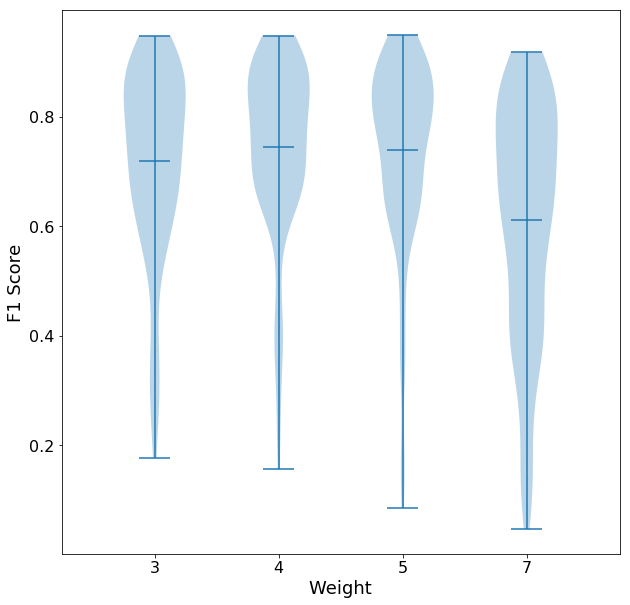

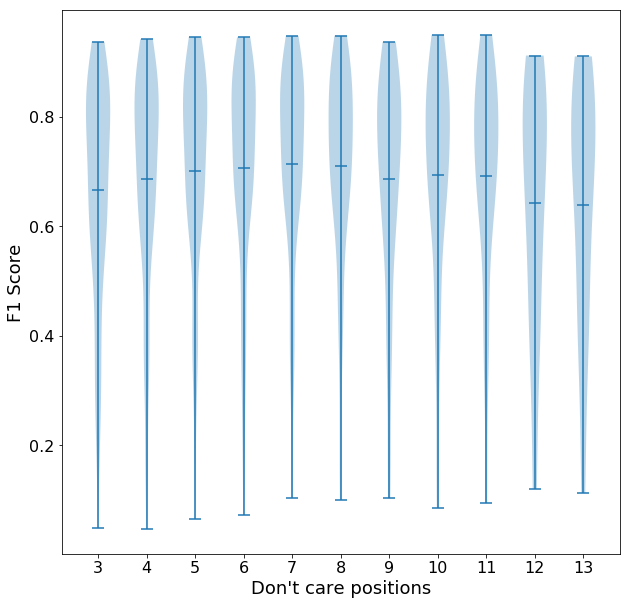

In [8]:
def set_axis_style(ax, labels, x_label='Weight'):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel(x_label)
    ax.set_ylabel('F1 Score')


f_scores_by_weight = defaultdict(list)
f_scores_by_dont_care = defaultdict(list)

for weight, dont_care, f_score in f_scores:
    f_scores_by_weight[weight].append(f_score)
    f_scores_by_dont_care[dont_care].append(f_score)

fig, ax = plt.subplots(figsize=(10,10))
f_scores_by_weight = sorted(f_scores_by_weight.items(), key=lambda el: el[0])
labels, f_score_data = unzip(f_scores_by_weight)
# plt.title('Violin plot of F1 scores by pattern weight')
plt.violinplot(f_score_data, showmeans=True, showextrema=True)
set_axis_style(ax, labels)
plt.savefig('f1-violin')

fig, ax = plt.subplots(figsize=(10,10))
f_scores_by_dont_care = sorted(f_scores_by_dont_care.items(), key=lambda el: el[0])
labels, f_score_data = unzip(f_scores_by_dont_care)
# plt.title('Violin plot of F1 scores by pattern weight')
plt.violinplot(f_score_data, showmeans=True, showextrema=True)
set_axis_style(ax, labels, x_label='Don\'t care positions')
plt.savefig('f1-violin-dont_care')

Text(0,0.5,'Execution times in ms')

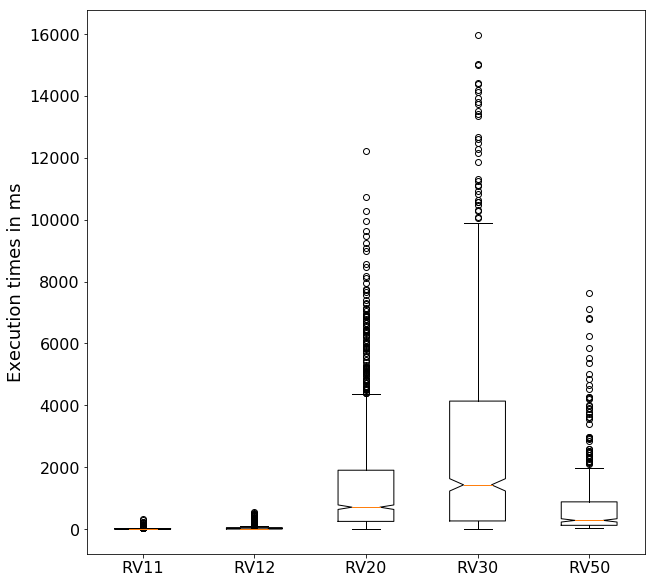

In [9]:
plt.figure(figsize=(10,10))
exec_times = {}
for (folder, by_weight) in data.items():
    exec_times[folder] = [result['alignment_execution_time_ms'] for result in flatten([item['results'] for item in flatten([by_dont_care.values() for by_dont_care in by_weight.values()])])]
folders, exec_times = unzip(sorted(exec_times.items(), key=lambda el: el))
# folders, exec_times = unzip(exec_times.items())
plt.boxplot(exec_times, notch=True, labels=folders)
plt.ylabel('Execution times in ms')

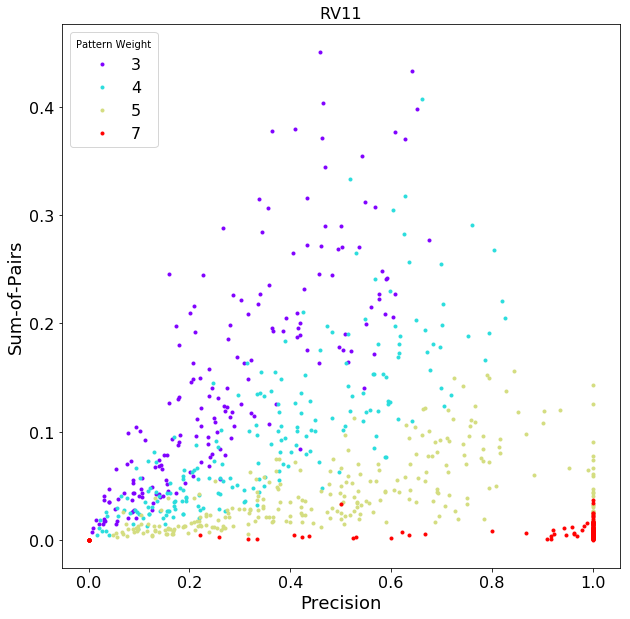

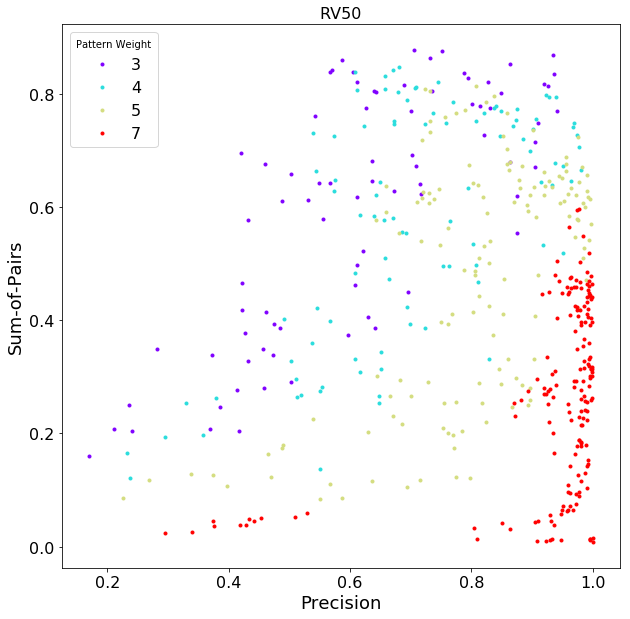

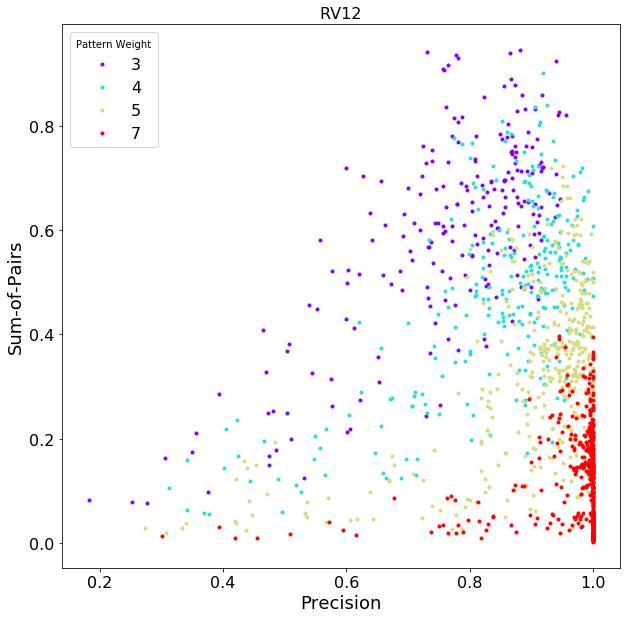

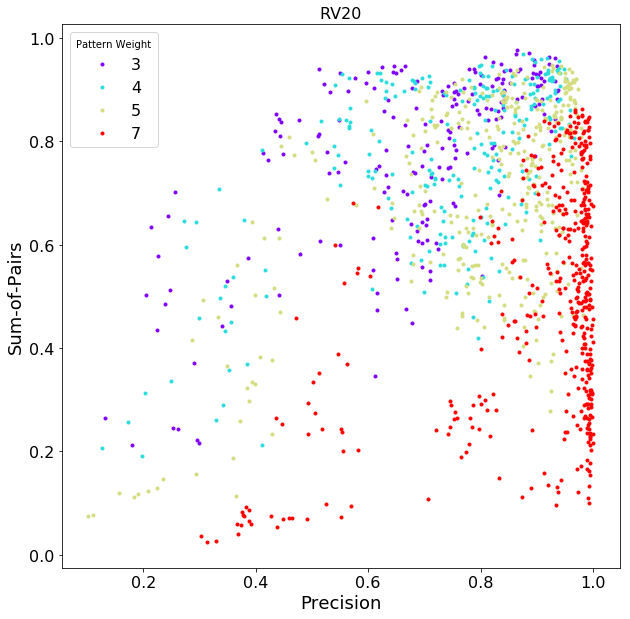

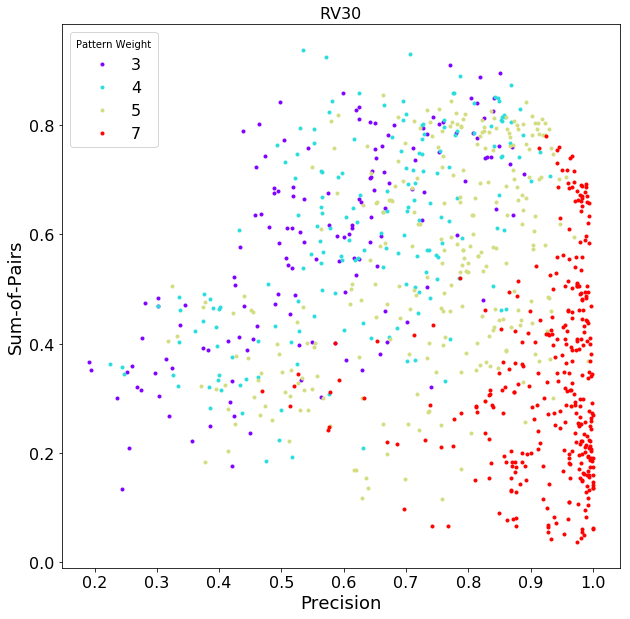

In [10]:
for category, by_weight in data.items():
    plt.figure(figsize=(10,10))
    colors=iter(plt.cm.rainbow(np.linspace(0,1,len(by_weight.keys()))))
    by_weight = sorted(by_weight.items(), key=lambda e: e[0])
    for color, (weight, by_dont_care) in zip(colors, by_weight):
        tmp_data = []
        for by_dont_care_val in by_dont_care.values():
            pr_data = [(item['precision'], item['sum_of_pairs']) for item in by_dont_care_val['results']]
            tmp_data += pr_data
        plt.scatter(*unzip(tmp_data), marker='.', color=color, label=weight)
    plt.xlabel('Precision')
    plt.ylabel('Sum-of-Pairs')
    plt.legend(title="Pattern Weight", loc='upper left')
    plt.title(category)
#     plt.savefig('prec-rec-scatter')    




In [ ]:
aggregated_scores = {}
for category, by_weight in data.items():
    aggr_by_weight = {}
    for weight, by_dont_care in by_weight.items():
        



In [15]:
for x in {'a':5}:
    print(x)

a
